In [17]:
%autosave 150
%matplotlib inline
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
from tqdm.notebook import tqdm

Autosaving every 150 seconds


# Load Data

In [2]:
def load_movielens_100k():
    # Load users
    u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
    users = pd.read_csv('data/ml-100k/u.user', sep='|', names=u_cols)

    # load ratings
    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv('data/ml-100k/u.data', sep='\t', names=r_cols)

    # Load movies
    m_cols = ['movie_id', 'title', 'release_date']
    movies = pd.read_csv('data/ml-100k/u.item', sep='|', names=m_cols, usecols=range(3), encoding='latin-1')

    # Join dataframes
    data = pd.merge(pd.merge(ratings, users), movies)
    data = data[['user_id','title', 'movie_id','rating','release_date','sex','age']]


    print("The DB has "+ str(data.shape[0]) +" ratings")
    print("The DB has ", data.user_id.nunique()," users")
    print("The DB has ", data.movie_id.nunique(), " movies")
    print(data.head())
    
    return data, users, ratings, movies

def load_movielens_1M():
    # Load users
    u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
    users = pd.read_csv('data/ml-1m/users.dat', sep='::', names=u_cols)

    # Load ratings
    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv('data/ml-1m/ratings.dat', sep='::', names=r_cols)

    # Load movies
    m_cols = ['movie_id', 'title', 'release_date']
    movies = pd.read_csv('data/ml-1m/movies.dat', sep='::', names=m_cols, usecols=range(3), encoding='latin-1')

    # Join dataframes
    data = pd.merge(pd.merge(ratings, users), movies)
    data = data[['user_id','title', 'movie_id','rating','release_date','sex','age']]


    print("The DB has "+ str(data.shape[0]) +" ratings")
    print("The DB has ", data.user_id.nunique()," users")
    print("The DB has ", data.movie_id.nunique(), " movies")
    print(data.head())
    
    return data, users, ratings, movies

# Matrix Factorization based

In [3]:
data, users, ratings, movies = load_movielens_1M()

E:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
E:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:33: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
E:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:37: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


The DB has 1000209 ratings
The DB has  6040  users
The DB has  3706  movies
   user_id                                   title  movie_id  rating  \
0        1  One Flew Over the Cuckoo's Nest (1975)      1193       5   
1        2  One Flew Over the Cuckoo's Nest (1975)      1193       5   
2       12  One Flew Over the Cuckoo's Nest (1975)      1193       4   
3       15  One Flew Over the Cuckoo's Nest (1975)      1193       4   
4       17  One Flew Over the Cuckoo's Nest (1975)      1193       5   

  release_date  sex age  
0        Drama    1   F  
1        Drama   56   M  
2        Drama   25   M  
3        Drama   25   M  
4        Drama   50   M  


In [4]:
user_item_matrix = data.pivot(index='user_id', columns='movie_id', values='rating')

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=42)

user_item_matrix_train = train.pivot(index='user_id', columns='movie_id', values='rating')
user_item_matrix_test = test.pivot(index='user_id', columns='movie_id', values='rating')

In [6]:
user_item_matrix_train.shape, user_item_matrix.shape

((6040, 3683), (6040, 3706))

In [7]:
u2idx = {u:idx for idx,u in enumerate(user_item_matrix.index.values)}
idx2u = {idx:u for idx,u in enumerate(user_item_matrix.index.values)}
i2idx = {i:idx for idx,i in enumerate(user_item_matrix.columns.values)} 
idx2i = {idx:i for idx,i in enumerate(user_item_matrix.columns.values)}

### SVD++

In [8]:
#items rated by user u
R_u = {u:user_item_matrix.columns[~user_item_matrix.loc[u].isna()] for u in user_item_matrix.index.values}
R_u_idx = {u:user_item_matrix.columns.isin(R_u[u]) for u in R_u.keys()}

In [9]:
bu = np.load('saved/svdpp/bu.npy')
bi = np.load('saved/svdpp/bi.npy')
pu = np.load('saved/svdpp/pu.npy')
qi = np.load('saved/svdpp/qi.npy')
yj = np.load('saved/svdpp/yj.npy')

mu = user_item_matrix.mean().mean()

In [10]:
def SVDpp_naive(user_item_matrix):
    #R_u = {u:user_item_matrix.columns[~user_item_matrix.loc[u].isna()] for u in user_item_matrix.index.values}
    #R_u_idx = {u:user_item_matrix.columns.isin(R_u[u]) for u in R_u.keys()}
    #hyperparams
    init_mu = 0
    init_sigma = 0.1
    latent_dim = 200
    n_epochs = 1
    gamma = 0.007
    lamb_bias = 0.02
    lamb_latent = 0.02


    #variables
    bu = np.zeros(user_item_matrix.shape[0])
    bi = np.zeros(user_item_matrix.shape[1])
    pu = np.random.normal(init_mu, init_sigma, (user_item_matrix.shape[0], latent_dim))
    qi = np.random.normal(init_mu, init_sigma, (user_item_matrix.shape[1], latent_dim))
    yj = np.random.normal(init_mu, init_sigma, (user_item_matrix.shape[1], latent_dim))
    mu = user_item_matrix.mean().mean()


    # algorithm
    for epoch in range(n_epochs):
        for i in user_item_matrix.columns.values:
            for u in user_item_matrix[~user_item_matrix[i].isna()].index.values:
                ii = i2idx[i]
                uu = u2idx[u]
                r = user_item_matrix[i].loc[u]

                wt = np.sqrt(R_u[u].shape[0])
                implicit_fbck = np.sum(yj[R_u_idx[u], :])/wt
                err = r - (mu + bu[uu] + bi[ii] + np.dot(qi[ii, :].T, pu[uu,:] + implicit_fbck))

                bu[uu] += gamma*(err-lamb_bias*bu[uu])
                bi[ii] += gamma*(err-lamb_bias*bi[ii])

                qi[ii,:] += gamma*(err*(pu[uu,:] + implicit_fbck) - lamb_latent*qi[ii,:])
                pu[uu,:] += gamma*(err*qi[ii,:] - lamb_latent*pu[uu,:])
                yj[ii,:] += gamma*(err/wt*qi[ii,:] - lamb_latent*yj[ii,:])

In [23]:
def compute_SVDpp(user_item_matrix, R_u, R_u_idx, idx2u,    
                  init_mu = 0,
                  init_sigma = 0.1,
                  latent_dim = 200,
                  n_epochs = 20,
                  gamma = 0.007,
                  lamb_latent = 0.015,
                  lamb_bias = 0.005):

    na_mask = np.isnan(user_item_matrix)
    
    #variables
    bu = np.zeros(user_item_matrix.shape[0])
    bi = np.zeros(user_item_matrix.shape[1])
    pu = np.random.normal(init_mu, init_sigma, (user_item_matrix.shape[0], latent_dim))
    qi = np.random.normal(init_mu, init_sigma, (user_item_matrix.shape[1], latent_dim))
    yj = np.random.normal(init_mu, init_sigma, (user_item_matrix.shape[1], latent_dim))
    mu = np.nanmean(user_item_matrix)

    np.seterr(all='print')

    # algorithm
    for epoch in tqdm(range(n_epochs)):
        for i in range(user_item_matrix.shape[1]):
            for u in np.where(~na_mask[:,i])[0]:
                
                r = user_item_matrix[u,i]
                Ru = R_u[idx2u[u]]
                Ru_idx = R_u_idx[idx2u[u]]

                wt = np.sqrt(Ru.shape[0])
                implicit_fbck = np.sum(yj[Ru_idx,:])/wt
                err = r - (mu + bu[u] + bi[i] + np.dot(qi[i, :].T, pu[u,:] + implicit_fbck))

                if(np.isnan(err)):
                    print("Overflow ocurred. Fiddle with the regularization parameters to avoid this!")
                    return None, None, None, None, None, None

                bu[u] += gamma*(err-lamb_bias*bu[u])
                bi[i] += gamma*(err-lamb_bias*bi[i])

                qi[i,:] += gamma*(err*pu[u,:]*(pu[u,:] + implicit_fbck) - lamb_latent*qi[i,:])
                pu[u,:] += gamma*(err*qi[i,:] - lamb_latent*pu[u,:])
                yj[i,:] += gamma*(err/wt*qi[i,:] - lamb_latent*yj[i,:])

    return bu, bi, pu, qi, yj, mu

##### Surprise code

In [32]:
import surprise
from surprise.prediction_algorithms.matrix_factorization import SVDpp
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

In [33]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25)

In [138]:
algo = SVDpp(n_factors=200, n_epochs=1)
%timeit algo.fit(trainset)

13min 1s ± 1min 59s per loop (mean ± std. dev. of 7 runs, 1 loop each)


##### Naive code with pandas implementation

In [68]:
%timeit SVDpp_naive(user_item_matrix)

E:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in multiply
E:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in multiply
E:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in subtract
E:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in multiply
E:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in add


5min 31s ± 14.3 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


##### Slightly more optimised with numpy

In [78]:
uim = user_item_matrix.to_numpy()
%timeit compute_SVDpp(uim, n_epochs=1)

E:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in multiply
E:\Programs\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


4min 20s ± 15.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


###### Final

In [12]:
u2idx_train = {u:idx for idx,u in enumerate(user_item_matrix_train.index.values)}
idx2u_train = {idx:u for idx,u in enumerate(user_item_matrix_train.index.values)}
i2idx_train = {i:idx for idx,i in enumerate(user_item_matrix_train.columns.values)} 
idx2i_train = {idx:i for idx,i in enumerate(user_item_matrix_train.columns.values)}
R_u_train = {u:user_item_matrix_train.columns[~user_item_matrix_train.loc[u].isna()] for u in user_item_matrix_train.index.values}
R_u_idx_train = {u:user_item_matrix_train.columns.isin(R_u[u]) for u in R_u.keys()}

In [13]:
R_u_idx_train_mask = {}
for u in user_item_matrix_train.index.values:
    R_u_idx_train_mask[u] = np.zeros(user_item_matrix_train.columns.shape[0], dtype=np.bool)
    R_u_idx_train_mask[u][R_u_idx_train[u]] = True

In [14]:
uim = user_item_matrix_train.to_numpy()

In [24]:
bu, bi, pu, qi, yj, mu = compute_SVDpp(uim, R_u_train, R_u_idx_train, idx2u_train, 
                                       gamma = 0.001,
                                       lamb_latent = 0.015,
                                       lamb_bias = 0.005)

In [25]:
np.save('saved/svdpp/bu.npy', bu)
np.save('saved/svdpp/bi.npy', bi)
np.save('saved/svdpp/pu.npy', pu)
np.save('saved/svdpp/qi.npy', qi)
np.save('saved/svdpp/yj.npy', yj)

##### Faster accesing yj[R_u]

In [82]:
%timeit yj[R_u_idx_train_mask[1], :]
%timeit yj[R_u_idx_train_mask[1]]
%timeit yj[R_u_idx_train_mask[1]]
%timeit yj[R_u_idx_train[1]]
cols = np.arange(0,200)
%timeit ix_ = np.ix_(R_u_idx_train[1], cols); yj[ix_]
%timeit np.take(yj, R_u_idx_train[1], axis=0)

R_u_idx_train_mask2 = {}
for u in user_item_matrix_train.index.values:
    R_u_idx_train_mask2[u] = np.zeros(yj.shape, dtype=np.bool)
    R_u_idx_train_mask2[u][R_u_idx_train[u], :] = True
%timeit yj[R_u_idx_train_mask2[1]]

%timeit np.compress(R_u_idx_train_mask[1], yj, axis=0)

newdict = {k: yj[R_u_idx_train[k]] for k in R_u_idx_train.keys()}
%timeit newdict[1]

12.9 µs ± 312 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
13.2 µs ± 423 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [28]:
faster_yj_dict = {k: yj[R_u_idx_train[k]] for k in R_u_idx_train.keys()}
faster_yj_sum_dict = {k: np.sum(yj[R_u_idx_train[k]]) for k in R_u_idx_train.keys()}

In [29]:
def predict(u, i):
    # This is a nuance of using train/test split. Since our dataset is split by surprise, let's use their functions
    uk = u in u2idx_train
    ik = i in i2idx_train
    
    r_hat = mu
    
    if uk:
        uu = u2idx_train[u]
        r_hat += bu[uu]
    
    if ik: 
        ii = i2idx_train[i]
        r_hat += bi[ii]
    
    if uk and ik:
        Ru = R_u_train[u]

        wt = np.sqrt(Ru.shape[0])
        implicit_fbck = faster_yj_sum_dict[u]/wt
        r_hat += np.dot(qi[ii, :].T, pu[uu,:] + implicit_fbck)
    
    return r_hat

In [30]:
predict(10,2)

3.7489817944490884

##### Rank

In [31]:
to_test = [x[0:2].tolist() for x in test[['user_id', 'movie_id', 'rating']].to_numpy() if x[2] == 5.0]

In [32]:
def precision_at_N(N):
    hits = 0
    na_mask = user_item_matrix_train.isna().to_numpy()
    for u,i in to_test:
        candidate_unseen_movies = np.where(na_mask[u2idx[u],:])[0]
        candidate_unseen_movies = np.random.choice(candidate_unseen_movies, size=100, replace=False)
        candidate_unseen_movies = np.unique(np.append(candidate_unseen_movies, i2idx[i]))
        unseen_movies_order_idx = np.argsort([predict(u,idx2i[ii]) for ii in candidate_unseen_movies])[::-1]
        sorted_unseen_movies = candidate_unseen_movies[unseen_movies_order_idx]
        p = np.where(sorted_unseen_movies == i2idx[i])[0]
        hits += p<=N
    recall_N = hits/len(to_test)
    precision_N = recall_N/(N+1)
    return recall_N, precision_N

In [33]:
scores = []
for N in tqdm(range(1,21)):
    scores.append(precision_at_N(N))

prec = [x[1] for x in scores]
rec = [x[0] for x in scores]

[]

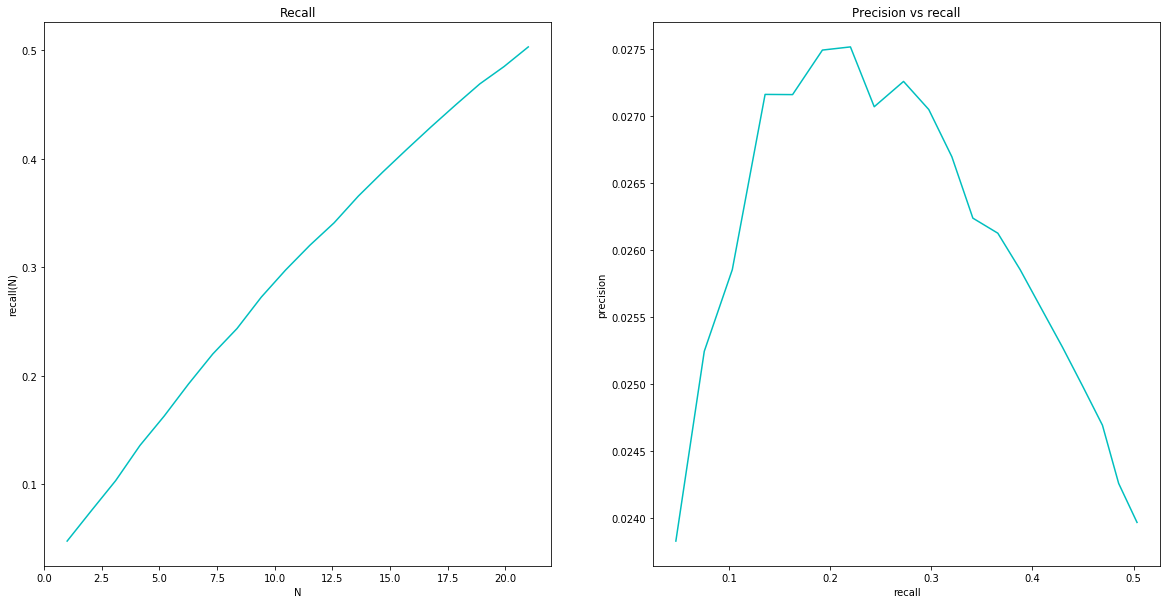

In [34]:
plt.figure(figsize=(20,10))

ax = plt.subplot(1,2,1)
ax.plot(np.linspace(1,21,num=20), rec, 'c-')
ax.set_xlabel('N')
ax.set_ylabel('recall(N)')
ax.set_title('Recall')

ax = plt.subplot(1,2,2)
ax.plot(rec, prec, 'c-')
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.set_title('Precision vs recall')

plt.plot()